## RUL prediction using boosting

In this notebook, we will apply boosting to predict RUL of NASA's turbofan engine dataset FD003. To implement boosting, we will use [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) library.

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(983)

In [2]:
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("XGBoost version: ", xgb.__version__)

Numpy version:  1.18.5
Pandas version:  1.0.5
XGBoost version:  1.2.0


## Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Linear
* Early RUL: None
* Window length: 1
* Shift: 1
* Data scaling: No (Tree based methods don't require data scaling)

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate. 

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly.

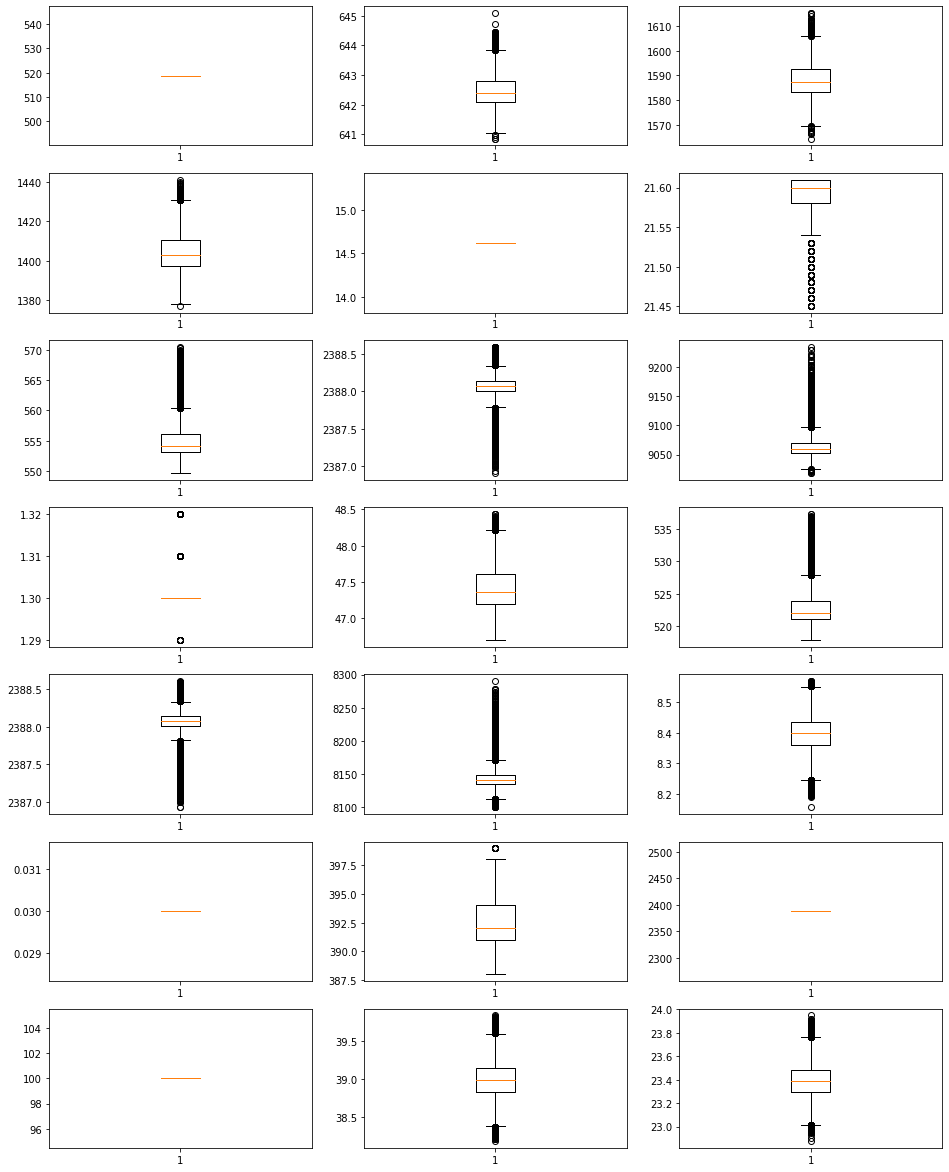

In [3]:
train_data = pd.read_csv("/home/biswajit/data/cmapss_data/train_FD003.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [4]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [5]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [6]:
test_data = pd.read_csv("/home/biswajit/data/cmapss_data/test_FD003.txt", sep = "\s+", header = None)
true_rul = pd.read_csv('/home/biswajit/data/cmapss_data/RUL_FD003.txt', sep = '\s+', header = None)

window_length = 1
shift = 1
early_rul = None            
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average of output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,14,20,22,23]

num_machines = np.min([len(train_data[0].unique()), len(test_data[0].unique())])

for i in np.arange(1, num_machines + 1):
    
    temp_train_data = train_data[train_data[0] == i].drop(columns=columns_to_be_dropped).values
    temp_test_data = test_data[test_data[0] == i].drop(columns=columns_to_be_dropped).values
    
    # Verify if data of given window length can be extracted from both training and test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    elif (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (24720, 1, 15)
Processed training ruls shape:  (24720,)
Processed test data shape:  (500, 1, 15)
True RUL shape:  (100,)


In [7]:
processed_train_data = processed_train_data.reshape(-1, processed_train_data.shape[2])
processed_test_data = processed_test_data.reshape(-1, processed_test_data.shape[2])
print("Processed train data shape: ", processed_train_data.shape)
print("Processed test data shape: ", processed_test_data.shape)

dtrain = xgb.DMatrix(processed_train_data, label = processed_train_targets)
dtest = xgb.DMatrix(processed_test_data)

Processed train data shape:  (24720, 15)
Processed test data shape:  (500, 15)


In [8]:
num_rounds = 500
params = {"max_depth":3, "learning_rate":1, "objective":"reg:squarederror"}
bst = xgb.train(params, dtrain, num_boost_round = num_rounds, evals = [(dtrain, "Train")], verbose_eval = 50)

[0]	Train-rmse:65.04383
[50]	Train-rmse:53.18308
[100]	Train-rmse:49.92238
[150]	Train-rmse:47.59803
[200]	Train-rmse:45.31795
[250]	Train-rmse:43.52437
[300]	Train-rmse:41.77406
[350]	Train-rmse:40.13785
[400]	Train-rmse:38.74412
[450]	Train-rmse:37.29040
[499]	Train-rmse:36.06504


In [9]:
rul_pred = bst.predict(dtest)

# First split predictions according to number of windows of each engine
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

RMSE:  48.48726960856917


With somewhat arbitrary choice of hyperparameters, we obtained an RMSE value of 48.48. But can we do better? To find out better values of hyperparameters, we can do a principled hyperparameter tuning. There are different ways to do hyperparameter search. Here, we will use simple grid search. 

In grid search, we first define a grid of parameters. Then for each set of parameters, we will fit a 10 xgboost models (as it is 10 fold cross validation). Finally we will average the result of all folds for a particular parameter choice. The parameter choice that gives best score for cross validation is chosen as the best hyperparameter.

Grid search of hyperparameters (with cross validation) is computationally intensive. It might take a long time on a personal computer. If that is the case, readers are advised to comment the next cell and directly use the best hyperparameter values as done in subsequent cells.

In [10]:
param_grid = [(max_depth, eta) for max_depth in np.arange(2,6) for eta in np.array([0.01, 0.1, 0.3, 0.5, 1])]

min_rmse = np.inf
best_params = None
params = dict()
params["objective"] = "reg:squarederror"
for max_depth, eta in param_grid:
    print("max_depth: {}, eta: {}".format(max_depth, eta))
    
    params["max_depth"] = max_depth
    params["eta"] = eta
    
    cv_res = xgb.cv(params, dtrain, num_boost_round= num_rounds, early_stopping_rounds= 10, nfold = 10, seed = 43)
    
    best_rmse_val = cv_res["test-rmse-mean"].min()
    best_num_rounds = cv_res["test-rmse-mean"].argmin() + 1
    
    print("RMSE: {} in {} rounds".format(best_rmse_val, best_num_rounds))
    print()
    
    if best_rmse_val < min_rmse:
        min_rmse = best_rmse_val
        best_params = (max_depth, eta, best_num_rounds)
        
print("Best parameters are: Max_depth= {}, eta= {}, num_rounds = {}. Corresponding RMSE: {}".format(best_params[0],
                                                                                                    best_params[1],
                                                                                                    best_params[2],
                                                                                                    min_rmse))

max_depth: 2, eta: 0.01
RMSE: 59.1461853 in 500 rounds

max_depth: 2, eta: 0.1
RMSE: 56.83812820000001 in 455 rounds

max_depth: 2, eta: 0.3
RMSE: 56.8100593 in 233 rounds

max_depth: 2, eta: 0.5
RMSE: 57.224615500000006 in 97 rounds

max_depth: 2, eta: 1.0
RMSE: 58.337023099999996 in 29 rounds

max_depth: 3, eta: 0.01
RMSE: 57.557504800000004 in 500 rounds

max_depth: 3, eta: 0.1
RMSE: 56.389996 in 248 rounds

max_depth: 3, eta: 0.3
RMSE: 56.6447628 in 108 rounds

max_depth: 3, eta: 0.5
RMSE: 57.259652700000004 in 53 rounds

max_depth: 3, eta: 1.0
RMSE: 58.7807008 in 25 rounds

max_depth: 4, eta: 0.01
RMSE: 56.7447411 in 500 rounds

max_depth: 4, eta: 0.1
RMSE: 56.2494594 in 146 rounds

max_depth: 4, eta: 0.3
RMSE: 56.770954100000004 in 33 rounds

max_depth: 4, eta: 0.5
RMSE: 57.273131099999986 in 30 rounds

max_depth: 4, eta: 1.0
RMSE: 58.6092319 in 9 rounds

max_depth: 5, eta: 0.01
RMSE: 56.2812667 in 500 rounds

max_depth: 5, eta: 0.1
RMSE: 56.2330283 in 91 rounds

max_depth: 5, et

We will use the best parameters to train the final regressor. The `num_boost_round` value obtained above is the best value for cross validation. We can take a value that is different from the above number but not very far from it. 

In [11]:
params_tuned = {"max_depth":5, "eta":0.1, "objective":"reg:squarederror"}
bst_tuned = xgb.train(params_tuned, dtrain, num_boost_round= 200)

rul_pred_tuned = bst_tuned.predict(dtest)

preds_for_each_engine_tuned = np.split(rul_pred_tuned, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine_tuned = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                                   for ruls_for_each_engine, num_windows in zip(preds_for_each_engine_tuned,
                                                                                num_test_windows_list)]
RMSE_tuned = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine_tuned))
print("RMSE after hyperparameter tuning: ", RMSE_tuned)

RMSE after hyperparameter tuning:  47.94765853845549


## Downside of having access to full test set

If we have access to full test set, to improve our score on test set, we can tune our algorithm so that it performs well on test set. **However, it should be noted that this is not the right way to train an algorithm.** Test set should be used only once (after model fine tuning) to predict our algorithm's generalization performance. **Test set should never be used to tune hyperparameters of our model.** If we tune our algorithm using test set, it might predict well on that set but there is no guarantee that it will generalize well for yet unseen data. 

To demonstrate the effect, in the cell below we have used some hyperparameters that gives considerably better results than that obtained by cross validation. How did I find those hyperparameters? As the full test set was available, I tried a few parameters using full test set and chose one that gave relatively better result. **I repeat this is just a hack (a poor one) to improve performance using test set.**

In [12]:
params_tuned = {"max_depth":4, "eta":0.01, "objective":"reg:squarederror"}
bst_tuned = xgb.train(params_tuned, dtrain, num_boost_round= 100)

rul_pred_tuned = bst_tuned.predict(dtest)

preds_for_each_engine_tuned = np.split(rul_pred_tuned, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine_tuned = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                                   for ruls_for_each_engine, num_windows in zip(preds_for_each_engine_tuned,
                                                                                num_test_windows_list)]
RMSE_tuned = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine_tuned))
print("RMSE after hyperparameter tuning: ", RMSE_tuned)

RMSE after hyperparameter tuning:  22.88913933379528


Note that while prediction, we are predicting RUL values for last 5 examples of every engine. Then we take mean of all 5 predictions for each engine and calculate final RMSE.

If instead we wish to take only the last example of every engine to make predictions and calculate RUL, we can do so by taking the last prediction of every engine as calculated before and calcutate RMSE as follows.

In [13]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
indices_of_last_examples

array([  4,   9,  14,  19,  24,  29,  34,  39,  44,  49,  54,  59,  64,
        69,  74,  79,  84,  89,  94,  99, 104, 109, 114, 119, 124, 129,
       134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194,
       199, 204, 209, 214, 219, 224, 229, 234, 239, 244, 249, 254, 259,
       264, 269, 274, 279, 284, 289, 294, 299, 304, 309, 314, 319, 324,
       329, 334, 339, 344, 349, 354, 359, 364, 369, 374, 379, 384, 389,
       394, 399, 404, 409, 414, 419, 424, 429, 434, 439, 444, 449, 454,
       459, 464, 469, 474, 479, 484, 489, 494, 499])

In [14]:
preds_for_last_example = np.concatenate(preds_for_each_engine_tuned)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  23.06931257896757


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where, 

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [15]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [16]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  2232.5292652111552


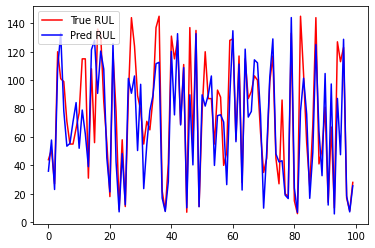

In [17]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

We can also plot variable importance score.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

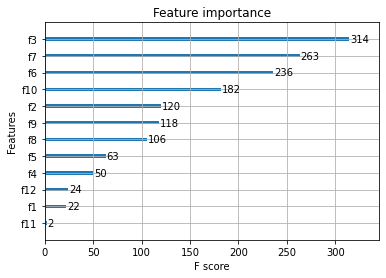

In [18]:
xgb.plot_importance(bst_tuned)

As a final note remember that hyperparameter tuning is more of an art than science. It is possible to obtain better results than what has been obtained here by choosing better set of hyperparameters.

For other reproducible results on RUL, interested readers can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open). 